In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from commando import ComManDo
from commando.evaluation import test_partial
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import torch

2022-02-23 00:34:11.733131: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-23 00:34:11.733184: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
data2 = np.loadtxt("../data/UnionCom/scGEM/GeneExpression.txt")
data1 = np.loadtxt("../data/UnionCom/scGEM/DNAmethylation.txt")
type1 = np.loadtxt("../data/UnionCom/scGEM/type1.txt")
type2 = np.loadtxt("../data/UnionCom/scGEM/type2.txt")
color_func = lambda x: {1:'#1f77b4', 2:'#ff7f0e', 3:'#2ca02c', 4:'#d62728', 5:'#9467BD'}[x]

np.random.seed(42)
idx = np.array(range(len(data1)))
np.random.shuffle(idx)
data1, data2 = (d[idx] for d in (data1,data2))
type1, type2 = (d[idx] for d in (type1,type2))

num_aligned = int(.6 * len(data2))
data1, data2, data1_withheld, data2_withheld = data1[:num_aligned], data2[:num_aligned], data1[num_aligned:], data2[num_aligned:]
type1_withheld, type2_withheld = type1[num_aligned:], type2[num_aligned:]

# Predict Missing Modality

In [4]:
# Align data
cm = ComManDo()
cm_data = cm.fit_transform(dataset=[data1,data2])

use random seed: 666
Shape of Raw data
Dataset 0: (106, 27)
Dataset 1: (106, 34)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[100/2000] err:2.2313 alpha:0.4635
epoch:[200/2000] err:1.7753 alpha:0.5150
epoch:[300/2000] err:1.1525 alpha:0.5718
epoch:[400/2000] err:0.9474 alpha:0.5961
epoch:[500/2000] err:0.8799 alpha:0.6049
epoch:[600/2000] err:0.8497 alpha:0.6094
epoch:[700/2000] err:0.8323 alpha:0.6124
epoch:[800/2000] err:0.8204 alpha:0.6147
epoch:[900/2000] err:0.8111 alpha:0.6166
epoch:[1000/2000] err:0.8029 alpha:0.6182
epoch:[1100/2000] err:0.7954 alpha:0.6197
epoch:[1200/2000] err:0.7882 alpha:0.6210
epoch:[1300/2000] err:0.7811 alpha:0.6221
epoch:[1400/2000] err:0.7741 alpha:0.6232
epoch:[1500/2000] err:0.7674 alpha:0.6242
epoch:[1600/2000] err:0.7610 alpha:0.6250
epoch:[1700/2000] err:0.7549 alpha:0.6258
epoch:[1800/2000] err:0.7493 alpha:0.6265
epoch:[1900/2000] err:0.7443 alpha:0.6271
epoch:[2000/2000] err:0.7398 alp

# Results

In [5]:
# Compile prediction and true
minmax = lambda d: (d - np.min(d)) / (np.max(d) - np.min(d))
predicted = minmax(cm.model.decoders[1](
    cm.model.encoders[0](
        torch.tensor(data1_withheld).float()
    )).detach().cpu().numpy())
actual = minmax(data2_withheld)

In [6]:
# Produce confusion matrix
# tn fp
# fn tp
confusion_matrix(actual.flatten() > .5,  predicted.flatten() > .5, labels=(False, True), normalize='true')

array([[0.91109853, 0.08890147],
       [0.35030864, 0.64969136]])

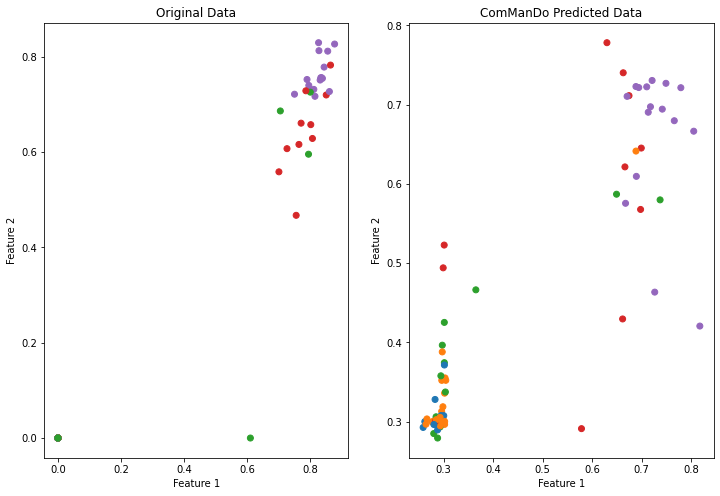

In [7]:
# Plot
f1,f2=0,1
colors = [color_func(i) for i in type2_withheld]
plt.subplots(1,2, figsize=(12,8))
plt.subplot(1,2,1)
plt.scatter(actual[:, f1], actual[:, f2], c=colors)
plt.title('Original Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.subplot(1,2,2)
plt.scatter(predicted[:, f1], predicted[:, f2], c=colors)
plt.title('ComManDo Predicted Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2');